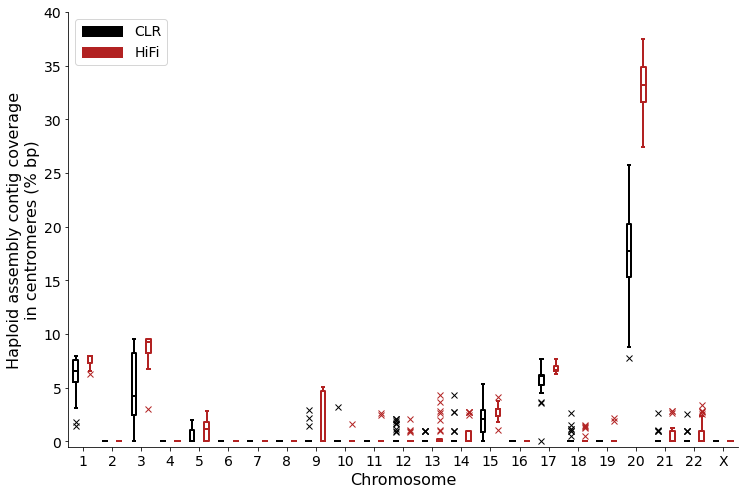

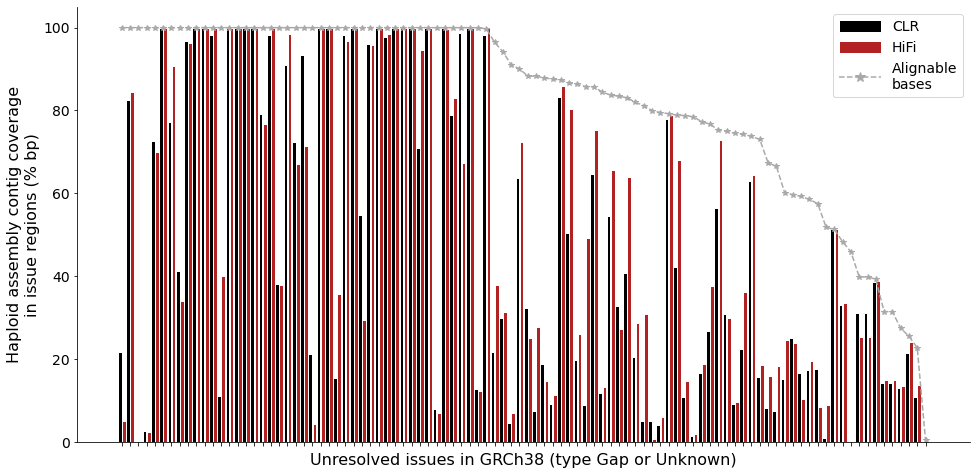

In [4]:
import os
import collections as col
import importlib
import re

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()
prop = plot_aux.get_plot_property

save_plots = True
print_stats = False

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/figSX_panels/assm_completeness'
out_path = os.path.join(stats_path, pipeline_version, 'figS{}_PE_hap-assm-ctgcov')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))

# cached data are the same as for
# assm_completeness notebook
df = pd.read_hdf(cache_file, 'cache').xs(['contig', 'fraction'], level=['input_type', 'stat_type'])
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'population', 'platform'])

def chrom_sort_order(x):
    
    if x == 'CENX':
        return 23
    try:
        srt_ord = int(x.strip('CEN'))
        return srt_ord
    except ValueError:
        return 0
        

def plot_region_coverage(sample_stats, region_stats, region_type):
    
    bar_width = prop('bar_width')
    
    x_pos_counter = 0
    
    if region_type == 'centromere':
        region_stats['sort_order'] = region_stats['name'].map(chrom_sort_order)
        region_stats = region_stats.loc[region_stats['sort_order'] > 0, :].copy()
        region_stats.sort_values('sort_order', inplace=True, axis=0)

        fig, axis = plt.subplots(figsize=(12,8))
    else:
        region_stats.sort_values(['accessible_pct', 'count_N'], inplace=True, ascending=False, axis=0)
        #region_stats['length'] = region_stats[[c for c in region_stats.columns if c.startswith('count_')]].sum()
        
        #region_stats.sort_values('length', inplace=True, ascending=False, axis=0)
        fig, axis = plt.subplots(figsize=(16,8))
    
    accessibility = []
    clr = {
        'x_pos': [],
        'y_mean': [],
        'y_err': []
    }
    hifi = {
        'x_pos': [],
        'y_mean': [],
        'y_err': []
    }
    gap_values = {
        'CLR': clr,
        'HiFi': hifi
    }
    for idx, row in region_stats.iterrows():
        
        if region_type == 'centromere':
            chrom_name = row['name'].replace('CEN', 'chr')
            tick_name = row['name'].replace('CEN', '')
            subset = sample_stats.xs(['CEN', chrom_name], level=['region_type', 'chrom'])
        else:
            if not (row['name'].startswith('Gap') or row['name'].startswith('Unknown')):
                continue
            subset = pd.concat([
                sample_stats.xs('Gap', level='region_type'),
                sample_stats.xs('Unknown', level='region_type')
            ], axis=0, ignore_index=False)
            subset = subset.loc[subset['name'] == row['name'], :].copy()
            tick_name = ''
    
        for platform in ['CLR', 'HiFi']:
            if platform == 'CLR':
                accessibility.append((x_pos_counter + 0.5, row.accessible_pct, tick_name))

            
            platform_values = subset.xs(platform, level='platform')

            platform_color = plot_aux.get_platform_color(platform)
            
            if region_type == 'centromere':
                axis.boxplot(
                    platform_values['coverage'],
                    notch=False,
                    sym='x' if region_type == 'centromere' else "",
                    widths=bar_width,
                    positions=[x_pos_counter],
                    boxprops={
                        'color': platform_color,
                        'linewidth': 2
                    },
                    meanprops={
                        'color': platform_color,
                        'linewidth': 2
                    },
                    medianprops={
                        'color': platform_color,
                        'linewidth': 2
                    },
                    whiskerprops={
                        'color': platform_color,
                        'linewidth': 2
                    },
                    flierprops={
                        'color': platform_color,
                        'linewidth': 2,
                        'markersize': 6,
                        'markerfacecolor': platform_color,
                        'markeredgecolor': platform_color
                    },
                    capprops={
                        'color': platform_color,
                        'linewidth': 2
                    }
                )
            else:
                mean = platform_values['coverage'].mean()
                stddev = platform_values['coverage'].std()
                gap_values[platform]['x_pos'].append(x_pos_counter)
                gap_values[platform]['y_mean'].append(mean)
                gap_values[platform]['y_err'].append(stddev)
                
            x_pos_counter += 1
    
    

    if region_type == 'centromere':
        axis.set_ylim(-0.5, 40)

        axis.set_xlabel(
            'Chromosome',
            fontsize=prop('fontsize_axis_label')
        )
    
        axis.set_ylabel(
            'Haploid assembly contig coverage\nin centromeres (% bp)',
            fontsize=prop('fontsize_axis_label')
        )
    else:
        for platform in ['CLR', 'HiFi']:
            
            positions = gap_values[platform]['x_pos']
            means = gap_values[platform]['y_mean']
            errors = gap_values[platform]['y_err']
            
            assert len(positions) == len(means) == len(errors), 'nope'
                        
            axis.bar(
                positions,
                height=means,
                width=0.9,
                color=plot_aux.get_platform_color(platform),
                #marker=prop('{}_marker'.format(platform)),
                edgecolor='white'
            )

        axis.plot(
            [t[0] for t in accessibility],
            [t[1] for t in accessibility],
            ls='dashed',
            c='darkgrey',
            marker='*'
        )
        axis.set_xlabel(
            'Unresolved issues in GRCh38 (type Gap or Unknown)',
            fontsize=prop('fontsize_axis_label')
        )
    
        axis.set_ylabel(
            'Haploid assembly contig coverage\nin issue regions (% bp)',
            fontsize=prop('fontsize_axis_label')
        )

    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

    axis.set_xticks([t[0] for t in accessibility])
    axis.set_xticklabels(t[2] for t in accessibility)
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    # build custom legend
    custom_patches = [
        patches.Patch(
            facecolor=plot_aux.get_platform_color('CLR'),
            edgecolor='white',
            label='CLR'
        ),
        patches.Patch(
            facecolor=plot_aux.get_platform_color('HiFi'),
            edgecolor='white',
            label='HiFi',
        ),
    ]
    if region_type != 'centromere':
        custom_patches.append(
            lines.Line2D(
                [0], [0],
                color='darkgrey',
                markersize=prop('legend_marker_size'),
                marker='*',
                ls='dashed',
                label='Alignable\nbases',
            )   
        )
    
    axis.legend(
        handles=custom_patches,
        loc='upper left' if region_type == 'centromere' else 'upper right',
        handlelength=3,
        handleheight=1,
        prop={'size': prop('fontsize_legend')}
    )
            
    extra_artists = []
    
    return fig, extra_artists

fig, exart = plot_region_coverage(df, pd.read_hdf(cache_file, 'nucprof/regions'), 'centromere')
supp_fig_num = 7
low_res_dpi = prop('dpi_low_res')
norm_res_dpi = prop('dpi_norm_res')

if save_plots:
    
    fig.savefig(
        out_path.format(supp_fig_num) + '_centromere.{}dpi.png'.format(low_res_dpi),
        dpi=low_res_dpi,
        bbox_inches='tight',
        extra_artists=exart
    )
    
    fig.savefig(
        out_path.format(supp_fig_num) + '_centromere.{}dpi.png'.format(norm_res_dpi),
        dpi=norm_res_dpi,
        bbox_inches='tight',
        extra_artists=exart
    )
    
    fig.savefig(
        out_path.format(supp_fig_num) + '_centromere.svg',
        bbox_inches='tight',
        extra_artists=exart
    )

fig, exart = plot_region_coverage(df, pd.read_hdf(cache_file, 'nucprof/issues'), 'other')
supp_fig_num = 12

if save_plots:
    fig.savefig(
        out_path.format(supp_fig_num) + '_issues.{}dpi.png'.format(low_res_dpi),
        dpi=low_res_dpi,
        bbox_inches='tight',
        extra_artists=exart
    )
    fig.savefig(
        out_path.format(supp_fig_num) + '_issues.{}dpi.png'.format(norm_res_dpi),
        dpi=norm_res_dpi,
        bbox_inches='tight',
        extra_artists=exart
    )
    fig.savefig(
        out_path.format(supp_fig_num) + '_issues.svg',
        bbox_inches='tight',
        extra_artists=exart
    )